In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 5
commitnumber = 5014a19
conc = None
dv = 0.01
klin = 2e-20
molecule = o3
ng_adju = [0, 0]
ng_refs = [2, 5]
nv = 100
option_compute_btable = 0
option_compute_ktable = 1
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (50, 250)]
tsfc = 294
vmax = 1100
vmin = 980
w_diffuse = [(1.6, 1.75), (1.55, 1.66, 1.7, 1.75, 1.8)]
wgt = [(0.35, 0.6), (0.5, 0.55, 0.7, 0.9, 1.0)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

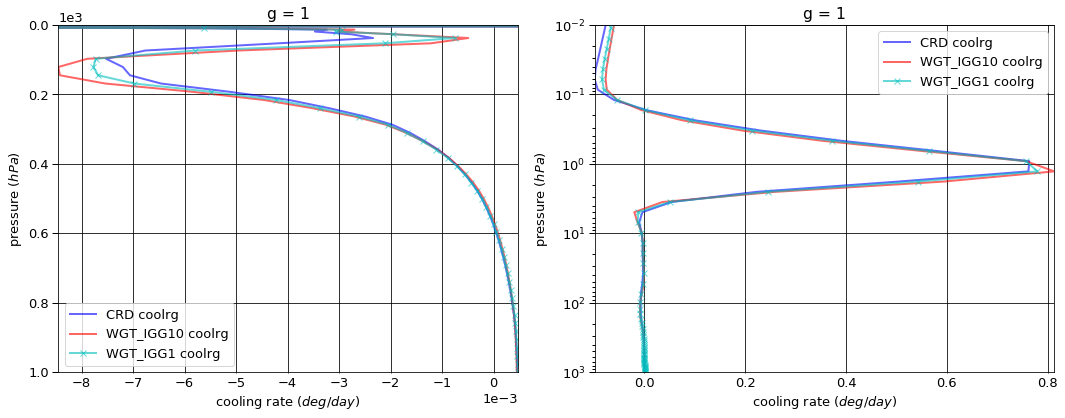

# Figure: cooling rate g-group 2

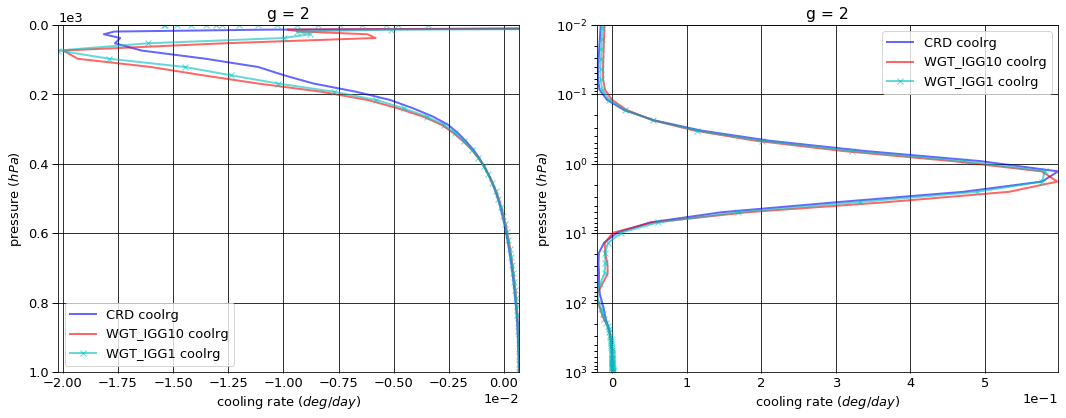

# Figure: cooling rate g-group 3

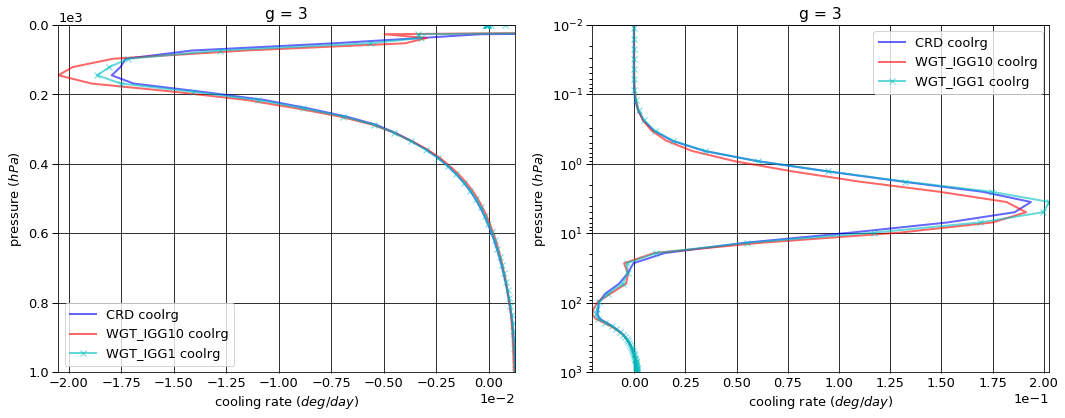

# Figure: cooling rate g-group 4

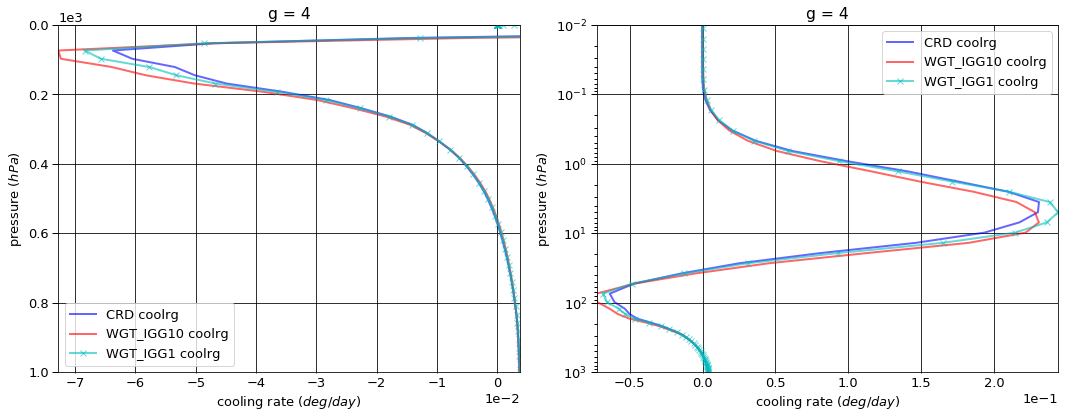

# Figure: cooling rate g-group 5

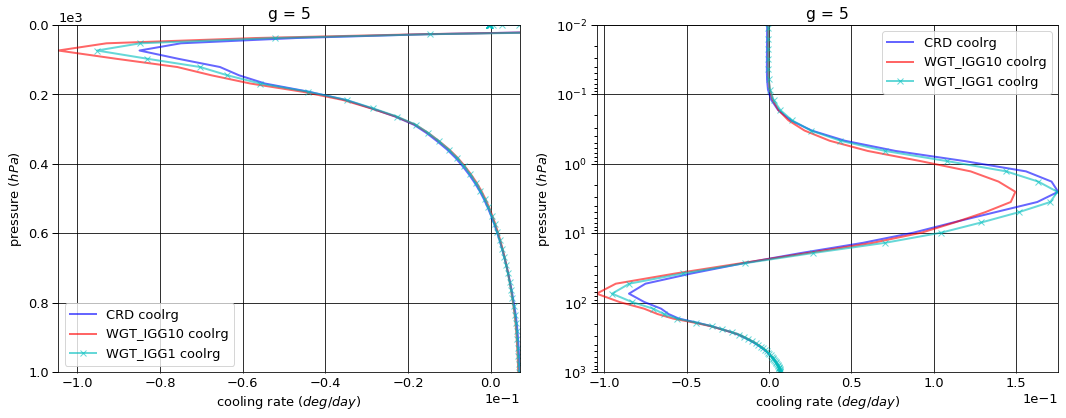

# Figure: cooling rate g-group 6

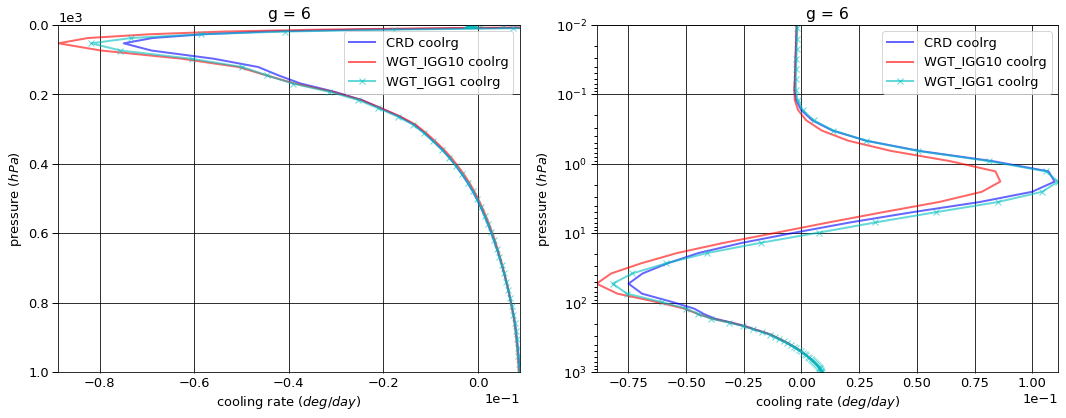

# Figure: cooling rate g-group 7

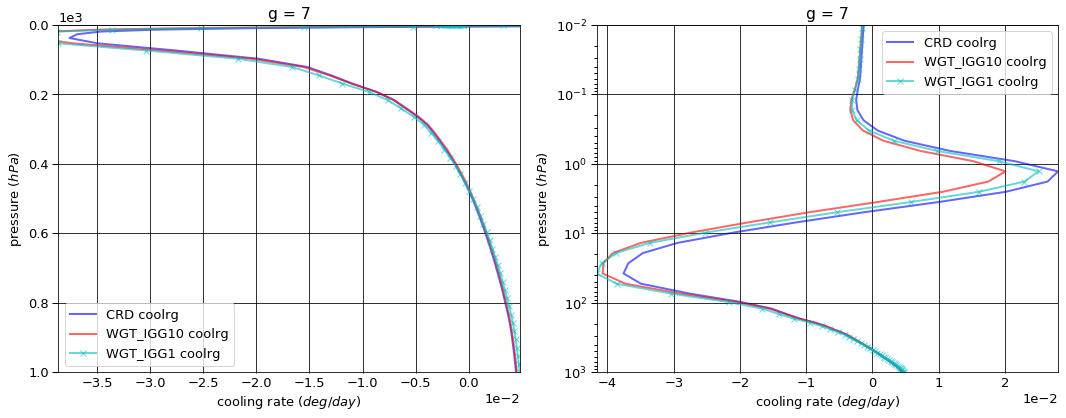

# Figure: cooling rate g-group total

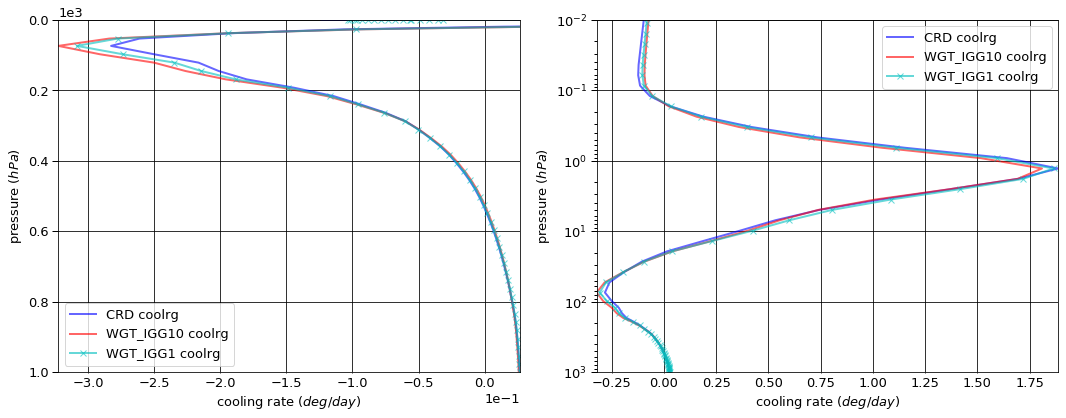

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.140173  0.000000  -0.140173
  1013.0   76     -0.252450  0.094034  -0.158417
2 0.0      1      -0.224568  0.000000  -0.224568
  1013.0   76     -0.472227  0.153695  -0.318532
3 0.0      1      -0.210393  0.000000  -0.210393
  1013.0   76     -0.635519  0.249398  -0.386121
4 0.0      1      -0.603201  0.000000  -0.603201
  1013.0   76     -2.173100  0.762228  -1.410871
5 0.0      1      -1.764565  0.000000  -1.764565
  1013.0   76     -4.394160  1.274654  -3.119507
6 0.0      1      -4.750994  0.000000  -4.750994
  1013.0   76     -7.144474  1.282419  -5.862054
7 0.0      1     -15.343291  0.000000 -15.343291
  1013.0   76    -16.282307  0.533530 -15.748777


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.145405  0.000000  -0.145405
  1013.0   76     -0.251622  0.091820  -0.159802
2 0.0      1      -0.228844  0.000000  -0.228844
  1013.0   76     -0.473500  0.150187  -0.323313
3 0.0      1      -0.211565  0.000000  -0.211565
  1013.0   76     -0.633629  0.239201  -0.394427
4 0.0      1      -0.565592  0.000000  -0.565592
  1013.0   76     -2.171439  0.742725  -1.428714
5 0.0      1      -1.587502  0.000000  -1.587502
  1013.0   76     -4.399531  1.246147  -3.153383
6 0.0      1      -4.645738  0.000000  -4.645738
  1013.0   76     -7.179509  1.271881  -5.907628
7 0.0      1     -15.272568  0.000000 -15.272568
  1013.0   76    -16.245007  0.538024 -15.706983


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.142711  0.000000  -0.142711
  1013.0   76     -0.251622  0.095170  -0.156453
2 0.0      1      -0.224395  0.000000  -0.224395
  1013.0   76     -0.473500  0.151901  -0.321599
3 0.0      1      -0.214709  0.000000  -0.214709
  1013.0   76     -0.633629  0.250742  -0.382887
4 0.0      1      -0.590643  0.000000  -0.590643
  1013.0   76     -2.171439  0.760030  -1.411409
5 0.0      1      -1.728995  0.000000  -1.728995
  1013.0   76     -4.399531  1.247260  -3.152270
6 0.0      1      -4.724430  0.000000  -4.724430
  1013.0   76     -7.179509  1.278141  -5.901368
7 0.0      1     -15.222957  0.000000 -15.222957
  1013.0   76    -16.245007  0.570927 -15.674080


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.005231  0.000000 -0.005231
  1013.0   76     0.000828 -0.002213 -0.001385
2 0.0      1     -0.004276  0.000000 -0.004276
  1013.0   76    -0.001273 -0.003508 -0.004781
3 0.0      1     -0.001172  0.000000 -0.001172
  1013.0   76     0.001890 -0.010197 -0.008306
4 0.0      1      0.037610  0.000000  0.037610
  1013.0   76     0.001661 -0.019504 -0.017843
5 0.0      1      0.177063  0.000000  0.177063
  1013.0   76    -0.005370 -0.028506 -0.033877
6 0.0      1      0.105255  0.000000  0.105255
  1013.0   76    -0.035035 -0.010539 -0.045574
7 0.0      1      0.070723  0.000000  0.070723
  1013.0   76     0.037300  0.004494  0.041794


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.002538  0.000000 -0.002538
  1013.0   76     0.000828  0.001136  0.001964
2 0.0      1      0.000173  0.000000  0.000173
  1013.0   76    -0.001273 -0.001794 -0.003067
3 0.0      1     -0.004316  0.000000 -0.004316
  1013.0   76     0.001890  0.001344  0.003234
4 0.0      1      0.012558  0.000000  0.012558
  1013.0   76     0.001661 -0.002198 -0.000538
5 0.0      1      0.035569  0.000000  0.035569
  1013.0   76    -0.005370 -0.027393 -0.032763
6 0.0      1      0.026563  0.000000  0.026563
  1013.0   76    -0.035035 -0.004279 -0.039314
7 0.0      1      0.120334  0.000000  0.120334
  1013.0   76     0.037300  0.037397  0.074697

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.030376
  1001.112500 75     0.000461
2 0.000312    1     -0.005774
  1001.112500 75     0.000670
3 0.000312    1     -0.000079
  1001.112500 75     0.001248
4 0.000312    1     -0.000176
  1001.112500 75     0.003760
5 0.000312    1     -0.000447
  1001.112500 75     0.007046
6 0.000312    1     -0.000739
  1001.112500 75     0.008834
7 0.000312    1     -0.000455
  1001.112500 75     0.004445


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1     -0.022896
  1001.112500 75     0.000450
2 0.000312    1     -0.003914
  1001.112500 75     0.000701
3 0.000312    1     -0.000027
  1001.112500 75     0.001186
4 0.000312    1      0.000001
  1001.112500 75     0.003667
5 0.000312    1     -0.000190
  1001.112500 75     0.006661
6 0.000312    1     -0.000716
  1001.112500 75     0.008621
7 0.000312    1     -0.000517
  1001.112500 75     0.004516


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1     -0.025468
  1001.112500 75     0.000471
2 0.000312    1     -0.004809
  1001.112500 75     0.000699
3 0.000312    1     -0.000053
  1001.112500 75     0.001262
4 0.000312    1     -0.000049
  1001.112500 75     0.003771
5 0.000312    1     -0.000213
  1001.112500 75     0.006831
6 0.000312    1     -0.000642
  1001.112500 75     0.008768
7 0.000312    1     -0.000521
  1001.112500 75     0.004800


WGT_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1      0.007480
  1001.112500 75    -0.000011
2 0.000312    1      0.001860
  1001.112500 75     0.000031
3 0.000312    1      0.000052
  1001.112500 75    -0.000062
4 0.000312    1      0.000177
  1001.112500 75    -0.000094
5 0.000312    1      0.000257
  1001.112500 75    -0.000386
6 0.000312    1      0.000024
  1001.112500 75    -0.000213
7 0.000312    1     -0.000063
  1001.112500 75     0.000071


WGT_IGG1 - CRD


coolrg
g pressure    layer          
1 0.000312    1      0.004908
  1001.112500 75     0.000009
2 0.000312    1      0.000966
  1001.112500 75     0.000029
3 0.000312    1      0.000026
  1001.112500 75     0.000014
4 0.000312    1      0.000128
  1001.112500 75     0.000010
5 0.000312    1      0.000235
  1001.112500 75    -0.000215
6 0.000312    1      0.000097
  1001.112500 75    -0.000066
7 0.000312    1     -0.000066
  1001.112500 75     0.000355

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-23.037185,0.000000,-23.037185
1013.0,76,-31.354237,4.349958,-27.004279



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-22.657214,0.000000,-22.657214
1013.0,76,-31.354237,4.279986,-27.074251



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-22.848841,0.000000,-22.848841
1013.0,76,-31.354237,4.354171,-27.000066



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,3.799714e-01,0.000000,0.379971
1013.0,76,8.600000e-07,-0.069972,-0.069972



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.883442e-01,0.000000,0.188344
1013.0,76,8.600000e-07,0.004213,0.004214


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.038047
1001.112500,75,0.026465



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.028258
1001.112500,75,0.025801



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.031754
1001.112500,75,0.026602



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.009788
1001.112500,75,-0.000664



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.006293
1001.112500,75,0.000136


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.008083,0.008025
2,0.014917,0.015102
3,0.020333,0.020209
4,0.069167,0.069255
5,0.139250,0.140317
6,0.224583,0.228981
7,0.523667,0.518112


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,3.908980e-18
2,6.241593e-19
3,8.928559e-19
4,2.517182e-19
5,7.096560e-20
6,2.000696e-20
7,1.116635e-22


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,3.908980e-18,NaN,0.008083,0.008025,0.008083,0.008025,1.0
2,6.241593e-19,0.159673,0.014917,0.015102,0.023000,0.023127,1.0
3,8.928559e-19,1.430494,0.020333,0.020209,0.043333,0.043335,50.0
4,2.517182e-19,0.281925,0.069167,0.069255,0.112500,0.112591,50.0
5,7.096560e-20,0.281925,0.139250,0.140317,0.251750,0.252907,50.0
6,2.000696e-20,0.281925,0.224583,0.228981,0.476333,0.481888,50.0
7,1.116635e-22,0.005581,0.523667,0.518112,1.000000,1.000000,50.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
